In [66]:
import numpy as np
import pandas as pd
import os, datetime
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

In [3]:
model_name = 'ST3000DM001'
data_dirs = ['../data-2015/']
attributes = ['smart_1_raw', 'smart_4_raw', 'smart_5_raw', 'smart_7_raw', 'smart_9_raw', 'smart_12_raw', 'smart_187_raw', 'smart_193_raw', 'smart_194_raw', 'smart_197_raw', 'smart_199_raw']
drive_models = ['ST4000DM000', 'ST3000DM001', 'Hitachi HDS5C3030ALA630', 'Hitachi HDS722020ALA330', 'Hitachi HDS5C4040ALE630', 'HGST HMS5C4040ALE640', 'HGST HMS5C4040BLE640']
features = ['serial_number', 'date', 'capacity_bytes', 'smart_5_raw', 'smart_1_raw', 'smart_4_raw', 'smart_7_raw', 'smart_9_raw', 'smart_12_raw', 'smart_187_raw', 'smart_193_raw', 'smart_194_raw', 'smart_197_raw', 'smart_199_raw', 'smart_196_raw']
type_dict = {feature: np.float32 for feature in features[3:]}

def model_stat(model, X, y):
    f_score = cross_val_score(model, X, y, cv=5, scoring='f1', n_jobs=-1)
    r_score = cross_val_score(model, X, y, cv=5, scoring='recall', n_jobs=-1)
    p_score = cross_val_score(model, X, y, cv=5, scoring='precision', n_jobs=-1)
    return pd.Series({'P': np.mean(p_score), 'R': np.mean(r_score), 'F': np.mean(f_score), 'Sd': np.std(f_score)})

statics = pd.DataFrame(index=['CART', 'SVM', 'NN', 'LR', 'RF'], columns=['P', 'R', 'F', 'Sd'])
statics

,P,R,F,Sd
CART,NaN,NaN,NaN,NaN
SVM,NaN,NaN,NaN,NaN
NN,NaN,NaN,NaN,NaN
LR,NaN,NaN,NaN,NaN
RF,NaN,NaN,NaN,NaN


In [4]:
for model_name in drive_models:
    drive_model = pd.concat([(lambda pd: pd.loc[pd['model'] == model_name][features])(pd.read_csv(os.path.join(data_dir, filename), dtype=type_dict)) for data_dir in data_dirs for filename in os.listdir(data_dir)]).sort_values(by=['serial_number', 'date'])
    drive_model.to_csv('./preprocess/' + model_name + '.csv')

In [5]:
res_vars = ['smart_5_raw', 'smart_187_raw', 'smart_196_raw', 'smart_197_raw']
overview = pd.DataFrame(index=drive_models, columns=res_vars+['Capacity (TB)', '# Drives'])
type_dict = {key: np.float64 for key in res_vars}

for model_name in drive_models:
    drive_model = pd.read_csv('./preprocess/' + model_name + '.csv', dtype=type_dict)
    percentage = drive_model.groupby('serial_number')[res_vars].sum().agg(lambda data: data[data>0].size/data.size)
    percentage['Capacity (TB)'] = drive_model.iloc[0]['capacity_bytes'] // 1000**4
    percentage['# Drives'] = drive_model['serial_number'].unique().size
    overview.loc[model_name] = percentage
    
overview.to_csv('./preprocess/overview.csv')
overview

,smart_5_raw,smart_187_raw,smart_196_raw,smart_197_raw,Capacity (TB),# Drives
ST4000DM000,0.00738119,0.0154702,0,0.0150657,4,29670
ST3000DM001,0.120719,0.177226,0,0.0702055,3,1168
Hitachi HDS5C3030ALA630,0.0323491,0,0.032132,0.0123752,3,4606
Hitachi HDS722020ALA330,0.133675,0,0.133675,0.0365151,2,4683
Hitachi HDS5C4040ALE630,0.0150376,0,0.0154135,0.0075188,4,2660
HGST HMS5C4040ALE640,0.0060317,0,0.0060317,0.00266517,4,7129
HGST HMS5C4040BLE640,0.000966806,0,0.000966806,0.00257815,4,3103


In [48]:
model_name = 'ST3000DM001'
drive_model = pd.read_csv('./preprocess/' + model_name + '.csv', dtype=type_dict).iloc[:, 1:]

In [49]:
df = drive_model.sort_values(by=['serial_number', 'date']).dropna(how='all', axis='columns')
df['date'] = pd.to_datetime(df['date'])
df.head()

,serial_number,date,capacity_bytes,smart_5_raw,smart_1_raw,smart_4_raw,smart_7_raw,smart_9_raw,smart_12_raw,smart_187_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_199_raw
0,S1F01085,2015-01-01,3000592982016,56.0,215630670.0,74.0,994661600.0,24621.0,71.0,52.0,407438.0,19.0,0.0,7.0
1,S1F01085,2015-01-02,3000592982016,56.0,1650864.0,74.0,995929540.0,24645.0,71.0,52.0,407438.0,19.0,0.0,7.0
2,S1F01085,2015-01-03,3000592982016,56.0,124017370.0,74.0,997235900.0,24669.0,71.0,52.0,407438.0,19.0,0.0,7.0
3,S1F01085,2015-01-04,3000592982016,56.0,128073224.0,74.0,998608100.0,24693.0,71.0,52.0,407439.0,19.0,0.0,7.0
4,S1F01085,2015-01-05,3000592982016,56.0,97393450.0,74.0,999190700.0,24717.0,71.0,52.0,408114.0,18.0,0.0,7.0


In [50]:
# week = ['W-SUN', 'W-MON', 'W-TUE', 'W-WED', 'W-THU', 'W-FRI', 'W-SAT']
df2 = df.copy()
df2['date'] += datetime.timedelta(days=1)

day = 'W-MON'
model_group = df.groupby(['serial_number', pd.Grouper(key='date', freq=day)])
y = model_group['smart_5_raw'].last().to_frame().rename({'smart_5_raw': 'y'}, axis='columns')

model_group2 = df2.groupby(['serial_number', pd.Grouper(key='date', freq=day)])
input1 = model_group2[[i for i in attributes if i in df2.columns]].last()

training_set = y.join(other=input1, how='inner')
training_set['y'] = np.where(training_set['y'] > training_set['smart_5_raw'], 1, 0)
input2_features = ['smart_4_raw', 'smart_5_raw', 'smart_7_raw', 'smart_9_raw', 'smart_12_raw', 'smart_187_raw', 'smart_193_raw', 'smart_197_raw', 'smart_199_raw']
input2 = training_set.groupby(level=0)[[i for i in input2_features if i in training_set.columns]].transform(pd.DataFrame.diff).dropna(how='any')
training_set = training_set.join(other=input2, how='inner', rsuffix='_increase')
    
training_set.to_csv('./preprocess/' + model_name + '_training_set.csv')
training_set.shape

(17637, 21)

In [51]:
training_set = pd.read_csv('./preprocess/' + model_name + '_training_set.csv').drop(['serial_number', 'date'], axis='columns')
training_set.head()

,y,smart_1_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_12_raw,smart_187_raw,smart_193_raw,smart_194_raw,...,smart_199_raw,smart_4_raw_increase,smart_5_raw_increase,smart_7_raw_increase,smart_9_raw_increase,smart_12_raw_increase,smart_187_raw_increase,smart_193_raw_increase,smart_197_raw_increase,smart_199_raw_increase
0,0,128832130.0,74.0,56.0,999259100.0,24742.0,71.0,52.0,409404.0,18.0,...,7.0,0.0,0.0,651000.0,49.0,0.0,0.0,1965.0,0.0,0.0
1,0,7441792.0,74.0,0.0,5201943.0,24743.0,71.0,0.0,404786.0,22.0,...,0.0,0.0,0.0,613681.0,47.0,0.0,0.0,1611.0,0.0,0.0
2,0,154306600.0,36.0,0.0,75275780.0,21209.0,36.0,0.0,250284.0,25.0,...,0.0,0.0,0.0,452290.0,169.0,0.0,0.0,9020.0,0.0,0.0
3,0,134005830.0,36.0,0.0,78245240.0,21377.0,36.0,0.0,256762.0,26.0,...,0.0,0.0,0.0,2969460.0,168.0,0.0,0.0,6478.0,0.0,0.0
4,0,90323900.0,38.0,0.0,82446490.0,21545.0,38.0,0.0,259359.0,26.0,...,0.0,2.0,0.0,4201250.0,168.0,2.0,0.0,2597.0,0.0,0.0


'smart_5_raw_increase'

In [52]:
training_set.columns

Index(['y', 'smart_1_raw', 'smart_4_raw', 'smart_5_raw', 'smart_7_raw',
       'smart_9_raw', 'smart_12_raw', 'smart_187_raw', 'smart_193_raw',
       'smart_194_raw', 'smart_197_raw', 'smart_199_raw',
       'smart_4_raw_increase', 'smart_5_raw_increase', 'smart_7_raw_increase',
       'smart_9_raw_increase', 'smart_12_raw_increase',
       'smart_187_raw_increase', 'smart_193_raw_increase',
       'smart_197_raw_increase', 'smart_199_raw_increase'],
      dtype='object')

In [53]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)


In [42]:
# tune DT
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
tree_to_code(dt_model, training_set.drop(['y'], axis='columns').columns)

NameError: name 'X_train' is not defined

In [89]:
training_set.drop(['y', 'smart_5_raw', 'smart_5_raw_increase'], axis='columns').columns[3]

'smart_9_raw'

In [83]:
# down sampling
X_health_raw = training_set.loc[training_set['y'] == 0].drop(['y', 'smart_5_raw', 'smart_5_raw_increase'], axis='columns').values
X_fail = training_set.loc[training_set['y'] == 1].drop(['y', 'smart_5_raw', 'smart_5_raw_increase'], axis='columns').values
n_clusters = X_fail.shape[0] // 5
# kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_jobs=-1).fit(X_health_raw)
kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=0, batch_size=50000).fit(X_health_raw)
X_health = np.concatenate([X_health_raw[np.argsort(kmeans.transform(X_health_raw)[:, j])[::-1][:10]] for j in range(0, n_clusters)], axis=0)
X_train_raw = np.concatenate((X_health, X_fail), axis=0)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_raw)
y_train = np.concatenate((np.zeros(X_health.shape[0]), np.ones(X_fail.shape[0])), axis=0) 

print(X_fail.shape)
print(X_train.shape)
print(y_train.shape)

(118, 18)
(348, 18)
(348,)


In [84]:
# cart, rf (20-100 trees), svm, neural networks (3 layers 100 nodes), logistic regression
X_transformed = PCA(n_components=0.95).fit_transform(X_train)
X_transformed.shape

(348, 9)

In [85]:
# tune LR
lr_model = LogisticRegressionCV(Cs=100, fit_intercept=True, cv=5, 
                                        dual=False, penalty='l2', scoring='f1', 
                                        solver='newton-cg',  max_iter=1000, class_weight='balanced',
                                        n_jobs=-1, refit=True, multi_class='ovr', random_state=0, verbose=1)
lr_model.fit(X_train, y_train)
statics.loc['LR'] = model_stat(lr_model, X_train, y_train)
statics.loc['LR']

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


P      0.875092
R      0.887319
F       0.86248
Sd    0.0745442
Name: LR, dtype: object

In [86]:
# tune LR
lr_model = LogisticRegressionCV(Cs=100, fit_intercept=True, cv=5, 
                                        dual=False, penalty='l2', scoring='f1', 
                                        solver='newton-cg',  max_iter=1000, class_weight='balanced',
                                        n_jobs=-1, refit=True, multi_class='ovr', random_state=0, verbose=1)
lr_model.fit(X_transformed, y_train)
statics.loc['LR'] = model_stat(lr_model, X_transformed, y_train)
statics.loc['LR']

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


P      0.860375
R      0.886957
F      0.849859
Sd    0.0805825
Name: LR, dtype: object

In [59]:
# print(np.sum(y))
# print(np.sum(y_train))
# training_set.loc[training_set['y'] == 1].drop(['y'], axis='columns').head()
rf_model.fit(X_train, y_train)
rf_model.feature_importances_

NameError: name 'rf_model' is not defined

In [60]:
# tune SVM
svm_model = SVC(C=1.05, kernel='rbf', gamma=0.05, class_weight='balanced', max_iter=-1, random_state=0)
statics.loc['SVM'] = model_stat(svm_model, X_transformed, y_train)
statics.loc['SVM']

P     0.834255
R     0.757971
F     0.754298
Sd    0.115433
Name: SVM, dtype: object

Feature ranking:
1. feature 2 (0.323833)
2. feature 3 (0.111671)
3. feature 5 (0.102283)
4. feature 11 (0.099037)
5. feature 1 (0.071705)
6. feature 6 (0.071186)
7. feature 4 (0.062352)
8. feature 15 (0.041416)
9. feature 7 (0.041189)
10. feature 9 (0.023053)
11. feature 0 (0.022485)
12. feature 8 (0.009711)
13. feature 12 (0.009114)
14. feature 10 (0.008876)
15. feature 16 (0.002075)
16. feature 13 (0.000014)
17. feature 14 (0.000000)
18. feature 17 (0.000000)


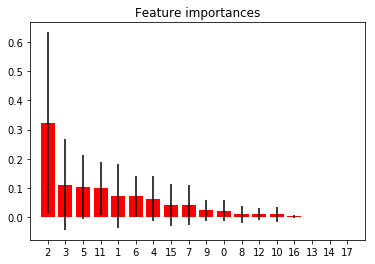

P         0.992
R       0.90471
F      0.963351
Sd    0.0326374
Name: RF, dtype: object

In [90]:
# tune RF
rf_model = RandomForestClassifier()

# Start
forest = rf_model
forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
# plt.xticks(df.columns.values, indices)
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# End

statics.loc['RF'] = model_stat(rf_model, X_transformed, y_train)
statics.loc['RF']

In [78]:
# # rf_model.fit(X_, y_train)
# print(rf_model.feature_importances_)
# training_set.loc[training_set['y'] == 0].drop(['y'], axis='columns').columns

In [91]:
# tune DT
dt_model = DecisionTreeClassifier()
statics.loc['CART'] = model_stat(dt_model, X_transformed, y_train)
statics.loc['CART']

P     0.990476
R     0.871014
F     0.926405
Sd    0.030712
Name: CART, dtype: object

In [92]:
# tune NN
nn_model = MLPClassifier(hidden_layer_sizes=(100, 100, 100))
statics.loc['NN'] = model_stat(nn_model, X_transformed, y_train)
statics.loc['NN']

P         0.992
R      0.888043
F      0.959316
Sd    0.0274438
Name: NN, dtype: object

In [93]:
statics.T.to_csv('./preprocess/' + model_name + '_finalstatics.csv')
statics.T

,CART,SVM,NN,LR,RF
P,0.990476,0.834255,0.992,0.860375,0.992
R,0.871014,0.757971,0.888043,0.886957,0.90471
F,0.926405,0.754298,0.959316,0.849859,0.963351
Sd,0.030712,0.115433,0.0274438,0.0805825,0.0326374
